In [1]:
#this is to auto-reload modules (like utils.py)
%load_ext autoreload
%autoreload 2

from IPython.core.display import display, HTML
from IPython.display import clear_output

import os
import sys
import time
import gc
import json
import glob
import ast

import shutil
import itertools



import utils

import numpy as np
import pandas as pd
# config to not reduce column width
pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', None)


import matplotlib.pyplot as plt
from matplotlib.colors import BoundaryNorm, ListedColormap

import seaborn as sns
plt.style.use('seaborn-whitegrid')

import plotly as ply
import plotly.express as px

from itertools import permutations, combinations

from tabulate import tabulate

import pickle
from joblib import dump, load


import sklearn
from sklearn.model_selection import StratifiedKFold

from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import ComplementNB, GaussianNB
from sklearn.neighbors import KNeighborsClassifier, RadiusNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier

from xgboost import XGBClassifier
from catboost import CatBoostClassifier
# import warnings
# warnings.simplefilter(action='ignore', category=FutureWarning)
# warnings.filterwarnings('always')

# Surpress warnings:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn


# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)


SMALL_SIZE = 10
MEDIUM_SIZE = 12
BIGGER_SIZE = 14

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=SMALL_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

%matplotlib inline  



### Read the performances obtained by GridSearch, and


In [2]:
csv_file = os.path.abspath('exec_results/validation_results_imbalance_learning.csv')

df = utils.read_csv(csv_file)

df['Extra_Info'] = df.Dataset + ' & '+ df.Features

df['Estimator'] = df.Estimator.apply(lambda x: utils.get_model_short_description(x))

cols_to_show = [
#     'Dataset',
#     'Features',
    'Estimator',
    'Extra_Info',
    'Valid_BalAcc',
    'Valid_Sens',
    'Valid_Spec',
#     'Valid_f1',
    'Valid_AUC',
#     'Valid_Acc',
#     'Valid_Prec',
    'Train_BalAcc',
    'Train_Sens',
    'Train_Spec',
#     'Train_f1',
    'Train_AUC',
#     'Train_Acc',
#     'Train_Prec',
]

df[cols_to_show].head(3)

,Estimator,Extra_Info,Valid_BalAcc,Valid_Sens,Valid_Spec,Valid_AUC,Train_BalAcc,Train_Sens,Train_Spec,Train_AUC
0,NN,Imbalanced & All Features,0.88,0.94,0.82,0.88,0.88,0.89,0.88,0.93
1,NN,Imbalanced & All Features,0.88,0.94,0.82,0.88,0.88,0.89,0.88,0.93
2,SVC,Imbalanced & All Features,0.87,0.94,0.80,0.87,0.88,0.89,0.87,0.93


##### Auxiliary functions

In [3]:
def plot_barplot_with_performances_by_model_and_scenario(df, hatched_bars=False, 
            annotate=False, figsize=[20,20], sort_columns=None, graph_title=None,
            remove_model_from_y_label=False, col_group_name='Model and Scenario'):

    col_model = 'Estimator'
    col_extra_info = 'Extra_Info'
    col_bacc = 'Valid_BalAcc'
    col_sens = 'Valid_Sens'
    col_spec = 'Valid_Spec'
    col_auc  = 'Valid_AUC'
    col_acc  = 'Valid_Acc'
    col_prec  = 'Valid_Prec'
    col_f1   = 'Valid_f1'
    
    if not remove_model_from_y_label:
        col_group = col_group_name
    else:
        col_group = 'Scenario'
    
    df_aux = df.copy()
    
    
    if sort_columns is None:
        sort_columns = [col_bacc, col_sens, col_spec]
    
    df_aux.sort_values(
        by=sort_columns, 
        ascending=False, 
        inplace=True,
    )
   
    
    if remove_model_from_y_label:
        df_aux[col_group] = df_aux[col_extra_info]
    else:
        df_aux[col_group] = df_aux[col_model] + ' (' + df_aux[col_extra_info] + ')'
    
    
    to_plot  =[
        ['Balanced Acc.', col_bacc],
        ['Sensitivity', col_sens],
        ['Specficity', col_spec],
#         ['AUC', col_auc],
#         ['f1 Score', col_f1],
#         ['Accuracy', col_acc],
#         ['Precision', col_prec],
    ]
    
    concat_dfs = []
    for desc, col in to_plot:
        # separate the each performance metric into dataFrames
        df_temp = df_aux[[col_group, col]].copy()
        df_temp.rename(columns={col: 'Performance'}, inplace=True)
        s_max = f' (max: {df_temp.Performance.max()})' if not annotate else ''
        df_temp['Metric'] = desc + s_max
        concat_dfs.append(df_temp)
        
    # concatenate all DFs
    df_graph = pd.concat(concat_dfs)

    # plot the graph
    plt.figure(figsize=figsize)
    ax = sns.barplot(
        data=df_graph, 
        x='Performance', 
        y=col_group, 
        hue='Metric',
        palette= sns.color_palette("colorblind") if not hatched_bars else None,
    )
    
    

    # if was to plot bar with hash instead of colors
    if hatched_bars:
        
#         hatches = [ "+" , "-", ".", "*","x", "o", "O"] #, "|" , "\\" , "/" ,  ]
        hatches = [ "|" , "\\" , "/" , "+" , "-", ".", "*","x", "o", "O" ]
        
        num_bars = 7
        i = 0
        for bar in ax.patches:
            if (i) % num_bars == 0:
                i = 0
            hatch = hatches[i]
            bar.set_hatch(hatch)
            bar.set_color('white')
            bar.set_edgecolor('black')
            i += 1
    
    
    # annotate the bars with their values
    if annotate and not hatched_bars:
        for p in ax.patches:
            ax.annotate(
                "%.2f" % p.get_width(), 
                xy=(
                    p.get_width()+ 0.015, 
                    p.get_y()+p.get_height()/2
                ),
                xytext=(5, 0), 
                textcoords='offset points', 
                ha="left", 
                va="center",
                size=10,
            )    


  
    plt.xlim(0, 1)
    plt.xticks([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])
    # red vertical line to highlight the performance threshold
    plt.axvline(x=0.8, color='r', ls=':', label='Performance Threshold')
    
    #place legend outside top right corner of plot
    plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

    if graph_title is not None:
        plt.title(graph_title)
    
    #
    plt.show()    
    plt.close()

    
    
    
    

    
    
# plot graph compraing 2 series    
def plot_side_by_side(df, filter_1, filter_2, col_to_filter, col_to_plot, cols_to_sort, ascending=True):
    
    df_1 = df.loc[(df[col_to_filter] == filter_1)].copy().sort_values(by=cols_to_sort, ascending=ascending)
    
    if filter_2 is not None:
        df_2 = df.loc[(df[col_to_filter] == filter_2)].copy().sort_values(by=cols_to_sort, ascending=ascending)
    else:
        df_2 = None
        
    utils.plot_series_side_by_side(
        series1=df_1[col_to_plot],
        series2=df_2[col_to_plot] if df_2 is not None else None,
        title_list=[filter_1, filter_2],
    )

    
    
    
    
def plot_valid_training_comparison(dfs, scenarios, show_lineplot=False):    

    for df_plot, scenario in zip(dfs, scenarios):
        y_train_line = df_plot.loc[(df_plot.Stage=='Train')][['Bal. Acc.', 'Sens.', 'Spec.']].values.ravel()
        y_valid_line = df_plot.loc[(df_plot.Stage=='Valid')][['Bal. Acc.', 'Sens.', 'Spec.']].values.ravel()
        
        utils.plot_performance_graph(
            y_train_line=y_train_line,
            y_valid_line=y_valid_line,
            graph_title=scenario,
            show_performance_threshold=True,
            show_lineplot=show_lineplot,
        )
        
def plot_alone_bagging_comparison(df, graph_title='Performances Comparison', show_lineplot=True, figsize=[6,2]):    

    plt.figure(figsize=figsize)
    plt.axhline(y=0.8, color='r', ls=':', label='Performance Threshold')

    g = sns.barplot(
        data=df, 
        x='Metric', 
        y='Performance', 
        hue='Scenario',
        palette= sns.color_palette("colorblind"),
    )            

    # annotate the bars with their values
    for p in g.axes.patches:
        g.annotate(
            "%.2f" % p.get_height(), 
            xy=(
                (p.get_x()+p.get_width()/2),
                    p.get_height() + 0.03
            ),
#                 xytext=(0, 0), 
            textcoords='offset points', 
            ha="center", 
            va="center",
            size=10,
        )    

    sns.move_legend(g.axes, "upper left", bbox_to_anchor=(1, 1))
    plt.ylim(0.50, 1.0)
    plt.yticks([.6, .7, .8, .9, 1.])
    plt.title(graph_title)

    plt.show()        

    

## Plot the performances by Model and Scenario

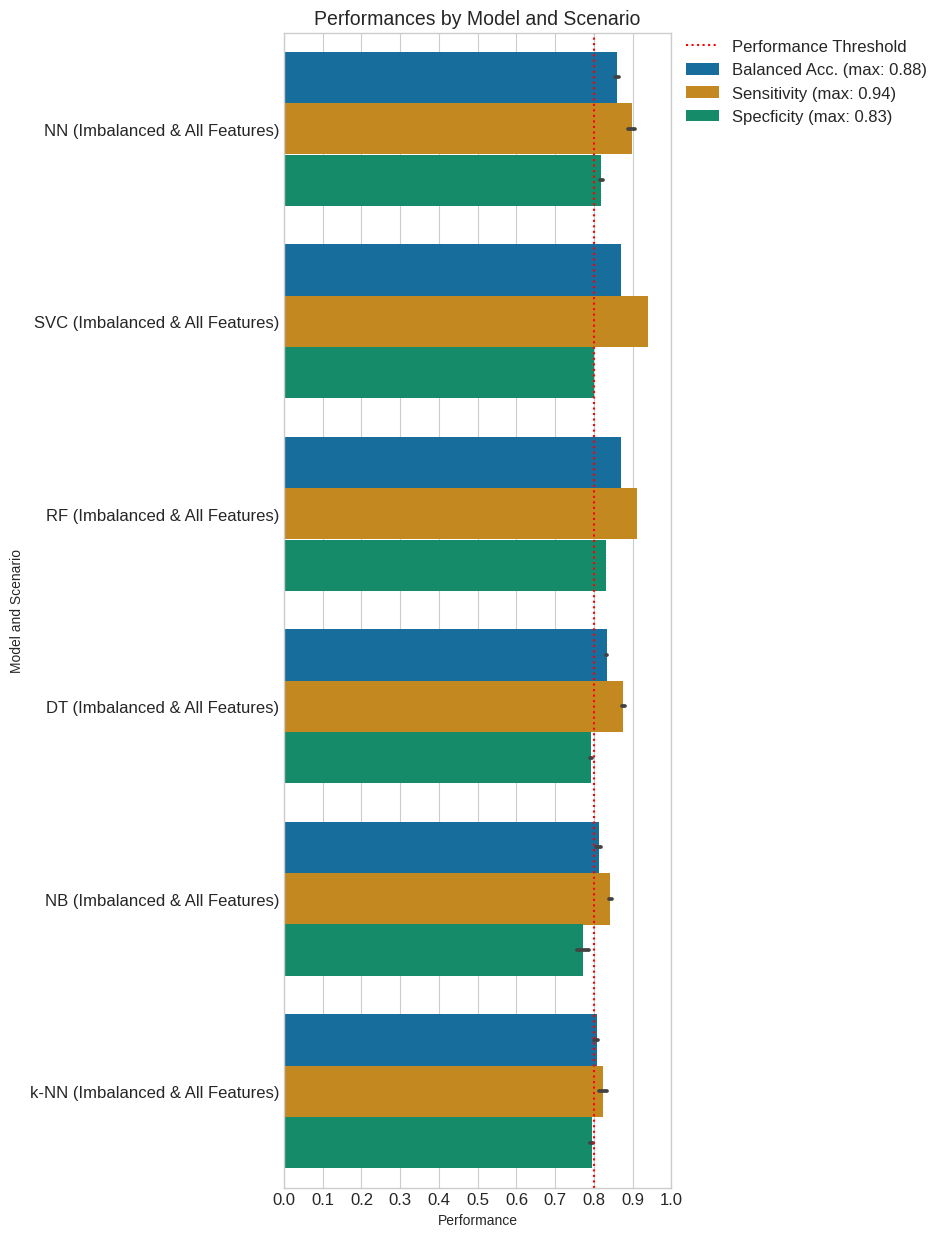

In [10]:
plot_barplot_with_performances_by_model_and_scenario(
    df=df, 
    figsize=[5,15],
    annotate=False,
    graph_title='Performances by Model and Scenario',

#     hatched_bars=True
#     sort_columns=['Valid_AUC', 'Valid_Sens', 'Valid_Spec']
)


---
---
# Plot $Training$ _vs._ $Validation$ performances

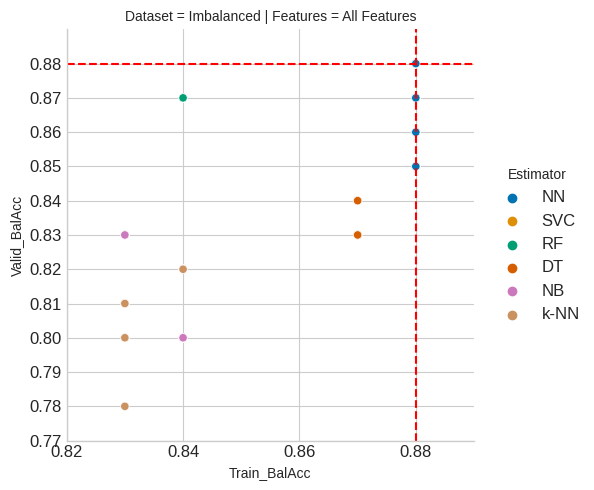

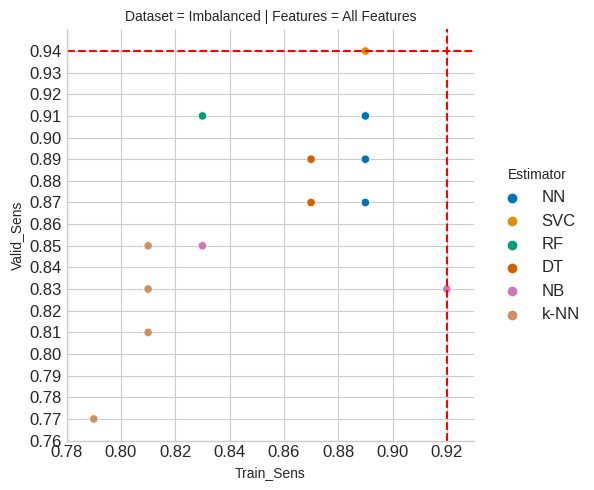

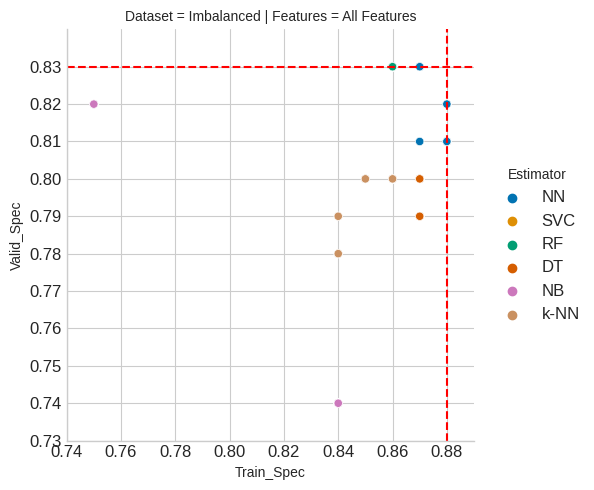

In [11]:
    
xs = ['Train_BalAcc', 'Train_Sens', 'Train_Spec']
ys = ['Valid_BalAcc', 'Valid_Sens', 'Valid_Spec'] 

df_performance_gt_80 = df.copy()

for x, y in zip(xs,ys):
    sns.set_palette('colorblind')
    g = sns.relplot(
        data=df_performance_gt_80,
        x=x,
        y=y, 
        hue='Estimator',
        row='Dataset',
        col='Features',
    )

    x_min = df_performance_gt_80[x].min()-0.01
    x_max = df_performance_gt_80[x].max()+0.01
    x_ticks = np.arange(x_min, x_max, 0.02)

    y_min = df_performance_gt_80[y].min()-0.01
    y_max = df_performance_gt_80[y].max()+0.01
    y_ticks = np.arange(y_min, y_max, 0.01)

    plt.xticks(x_ticks)
    plt.yticks(y_ticks)
    plt.ylim(y_min, y_max)
    plt.xlim(x_min, x_max)

    g.refline(y=df_performance_gt_80[y].max(), color='red', linestyle='--')
    g.refline(x=df_performance_gt_80[x].max(), color='red', linestyle='--')

    plt.show()

---
## Compare $Training$ and  $Validation$ performances 

### Prepare the data and show the performances

Dataset,Bal. Acc.,Sens.,Spec.
Training,0.77,0.61,0.94
Validation,0.77,0.60,0.95
Diff,+0%,-1%,+1%
Dataset,Bal. Acc.,Sens.,Spec.
Training,0.88,0.89,0.88
Validation,0.88,0.94,0.82
Diff,+0%,+4%,-6%


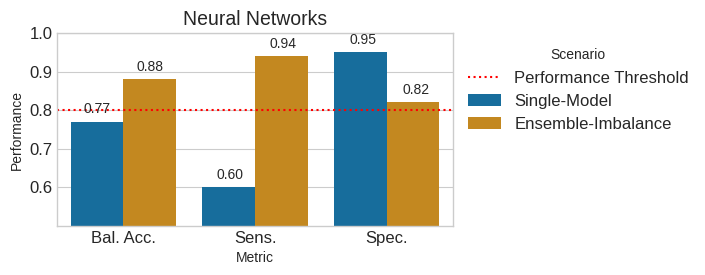

Dataset,Bal. Acc.,Sens.,Spec.
Training,0.83,0.82,0.85
Validation,0.85,0.89,0.82
Diff,+2%,+7%,-3%
Dataset,Bal. Acc.,Sens.,Spec.
Training,0.88,0.89,0.87
Validation,0.87,0.94,0.80
Diff,-1%,+4%,-6%


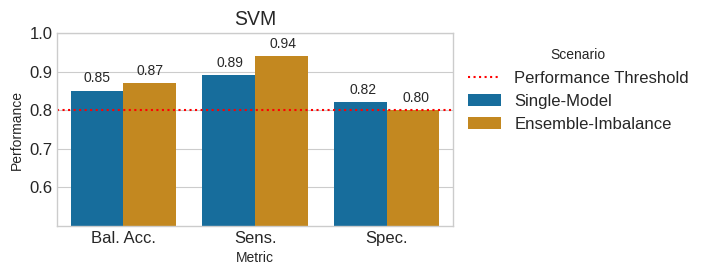

Dataset,Bal. Acc.,Sens.,Spec.
Training,0.70,0.44,0.96
Validation,0.73,0.51,0.95
Diff,+3%,+7%,-1%
Dataset,Bal. Acc.,Sens.,Spec.
Training,0.84,0.83,0.86
Validation,0.87,0.91,0.83
Diff,+3%,+8%,-3%


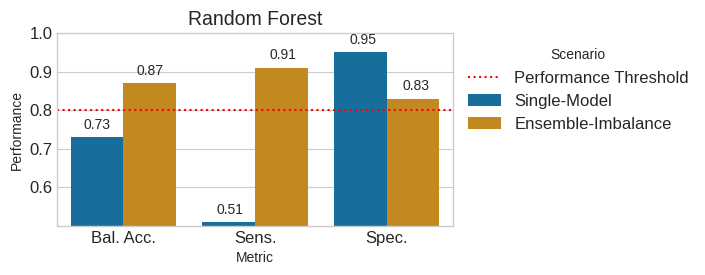

Dataset,Bal. Acc.,Sens.,Spec.
Training,0.78,0.83,0.74
Validation,0.79,0.91,0.67
Diff,+1%,+8%,-6%
Dataset,Bal. Acc.,Sens.,Spec.
Training,0.87,0.87,0.87
Validation,0.84,0.89,0.79
Diff,-3%,+2%,-7%


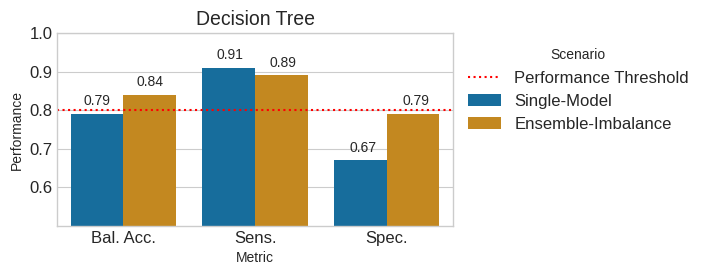

Dataset,Bal. Acc.,Sens.,Spec.
Training,0.79,0.78,0.79
Validation,0.80,0.85,0.75
Diff,+1%,+6%,-4%
Dataset,Bal. Acc.,Sens.,Spec.
Training,0.83,0.92,0.75
Validation,0.83,0.83,0.82
Diff,+0%,-9%,+6%


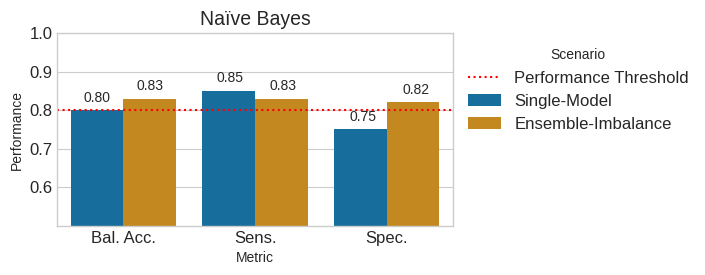

Dataset,Bal. Acc.,Sens.,Spec.
Training,0.74,0.80,0.68
Validation,0.74,0.81,0.68
Diff,+0%,+1%,+0%
Dataset,Bal. Acc.,Sens.,Spec.
Training,0.84,0.81,0.86
Validation,0.82,0.85,0.80
Diff,-2%,+3%,-5%


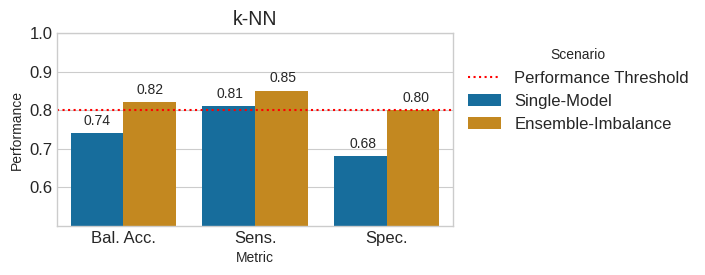

,Model,Scenario,Bal. Acc.,Sens.,Spec.
1,Decision Tree,Ensemble-Imbalance,0.84,0.89,0.79
1,Decision Tree,Single-Model,0.79,0.91,0.67
1,Naïve Bayes,Ensemble-Imbalance,0.83,0.83,0.82
1,Naïve Bayes,Single-Model,0.8,0.85,0.75
1,Neural Networks,Ensemble-Imbalance,0.88,0.94,0.82
1,Neural Networks,Single-Model,0.77,0.6,0.95
1,Random Forest,Ensemble-Imbalance,0.87,0.91,0.83
1,Random Forest,Single-Model,0.73,0.51,0.95
1,SVM,Ensemble-Imbalance,0.87,0.94,0.8
1,SVM,Single-Model,0.85,0.89,0.82


\begin{tabular}{lllll}
\toprule
          Model &           Scenario & Bal. Acc. & Sens. & Spec. \\
\midrule
  Decision Tree & Ensemble-Imbalance &      0.84 &  0.89 &  0.79 \\
  Decision Tree &       Single-Model &      0.79 &  0.91 &  0.67 \\
    Naïve Bayes & Ensemble-Imbalance &      0.83 &  0.83 &  0.82 \\
    Naïve Bayes &       Single-Model &      0.80 &  0.85 &  0.75 \\
Neural Networks & Ensemble-Imbalance &      0.88 &  0.94 &  0.82 \\
Neural Networks &       Single-Model &      0.77 &  0.60 &  0.95 \\
  Random Forest & Ensemble-Imbalance &      0.87 &  0.91 &  0.83 \\
  Random Forest &       Single-Model &      0.73 &  0.51 &  0.95 \\
            SVM & Ensemble-Imbalance &      0.87 &  0.94 &  0.80 \\
            SVM &       Single-Model &      0.85 &  0.89 &  0.82 \\
           k-NN & Ensemble-Imbalance &      0.82 &  0.85 &  0.80 \\
           k-NN &       Single-Model &      0.74 &  0.81 &  0.68 \\
\bottomrule
\end{tabular}



In [9]:
# ====================================================================
# GET THE RESULTS WITHOUT USING BALANCED-BAGGING
# ====================================================================

csv_file = 'exec_results/validation_results_for_best_models.csv'
df_results_without_balanced = utils.read_csv(csv_file)

df_results_without_balanced = df_results_without_balanced.loc[(
    (df_results_without_balanced.Dataset  == 'Imbalanced')
   &(df_results_without_balanced.Features == 'All Features')
)].copy()

df_results_without_balanced = df_results_without_balanced.groupby(
    by=['Model']
).first().reset_index(drop=False)

df_results_without_balanced['Model'] = df_results_without_balanced['Model'].apply(
    lambda x: utils.get_model_description(x)
)



# ====================================================================
# ====================================================================
# ====================================================================

csv_file = os.path.abspath('exec_results/validation_results_imbalance_learning.csv')

df_compare_train_valid = utils.read_csv(csv_file)

df_compare_train_valid['Extra_Info'] = df_compare_train_valid.Dataset + ' & '+ df_compare_train_valid.Features

df_compare_train_valid['Estimator'] = df_compare_train_valid['Estimator'].apply(
    lambda x: utils.get_model_description(x)
)

df_compare_train_valid = df_compare_train_valid.sort_values(by=[
    'Estimator', 
    'Valid_BalAcc', 
    'Valid_Sens', 
    'Valid_Spec', 
], ascending=False)

df_compare_train_valid = df_compare_train_valid.groupby(
    by=['Estimator', 'Dataset', 'Features']
).first().reset_index()


df_compare_train_valid = df_compare_train_valid.sort_values(by=[
    'Valid_BalAcc', 
    'Valid_Sens', 
    'Valid_Spec', 
], ascending=False)


## show the performances

cols_print = [
    'Bal. Acc.', 
    'Sens.', 
    'Spec.', 
]

models = df_compare_train_valid.Estimator.unique()
datasets = df_compare_train_valid.Dataset.unique()
features = df_compare_train_valid.Features.unique()

df_all_models = None

# display performance as table for each model and scenario    
for model in models:
    dfs = []
    captions = []
    model_desc = utils.get_model_description(model)

    for dataset in datasets:
        for feature in features:
            # MODEL ALONE =================================================
            df_temp = df_results_without_balanced.loc[
                (df_results_without_balanced.Model == model)
               &(df_results_without_balanced.Dataset  == dataset)
               &(df_results_without_balanced.Features == feature)
            ].copy()
            
            if df_temp.shape[0] > 0:
                
                data = {
                    'Dataset': ['Training', 'Validation', 'Diff'], 
                    'Bal. Acc.': [
                        df_temp.Train_BalAcc.values[0], 
                        df_temp.Valid_BalAcc.values[0],
                        f'{int((df_temp.Valid_BalAcc.values[0] - df_temp.Train_BalAcc.values[0])*100):+}%'
                    ], 
                    'Sens.': [
                        df_temp.Train_Sens.values[0], 
                        df_temp.Valid_Sens.values[0],
                        f'{int((df_temp.Valid_Sens.values[0] - df_temp.Train_Sens.values[0])*100):+}%'
                    ], 
                    'Spec.': [
                        df_temp.Train_Spec.values[0], 
                        df_temp.Valid_Spec.values[0],
                        f'{int((df_temp.Valid_Spec.values[0] - df_temp.Train_Spec.values[0])*100):+}%'
                    ],
                }
                
                df_temp = pd.DataFrame(data)
                dfs.append(df_temp)
                
                captions.append('Single-Model')
        

            # BALANCED-BAGGING =================================================
           
            df_temp = df_compare_train_valid.loc[
                (df_compare_train_valid.Estimator == model)
               &(df_compare_train_valid.Dataset  == dataset)
               &(df_compare_train_valid.Features == feature)
            ].copy()
            
            if df_temp.shape[0] > 0:
                
                data = {
#                     'Approach': ['Ensemble-Balanced Model'],
                    'Dataset': ['Training', 'Validation', 'Diff'], 
                    'Bal. Acc.': [
                        df_temp.Train_BalAcc.values[0], 
                        df_temp.Valid_BalAcc.values[0],
                        f'{int((df_temp.Valid_BalAcc.values[0] - df_temp.Train_BalAcc.values[0])*100):+}%'
                    ], 
                    'Sens.': [
                        df_temp.Train_Sens.values[0], 
                        df_temp.Valid_Sens.values[0],
                        f'{int((df_temp.Valid_Sens.values[0] - df_temp.Train_Sens.values[0])*100):+}%'
                    ], 
                    'Spec.': [
                        df_temp.Train_Spec.values[0], 
                        df_temp.Valid_Spec.values[0],
                        f'{int((df_temp.Valid_Spec.values[0] - df_temp.Train_Spec.values[0])*100):+}%'
                    ],
                }
                
                df_temp = pd.DataFrame(data)
                dfs.append(df_temp)
                
                captions.append('Ensemble-Imbalance')

                
                

#     model_desc = utils.get_model_description(model)
    display(HTML(f'<div style="border:2px solid gray">'))
    display(HTML(f'<h3>{model_desc}</h3>'))
    output = utils.display_side_by_side(
        dfs=dfs, 
        captions= captions
    )
    display(HTML(output))
    display(HTML(f'</div>'))


    # PREPARE TO PLOT COMPARISON BETWEEN SCENARIO ===================
    df_joined = None
    
    df_alone = dfs[0].copy()
    df_bbag  = dfs[1].copy()
    
    df_alone = df_alone.loc[(df_alone.Dataset == 'Validation')]
    df_bbag  = df_bbag.loc[(df_bbag.Dataset == 'Validation')]
    
    dfs = [df_alone, df_bbag]

    # separate data by scenario
    for i, df_aux in enumerate(dfs):
        scenario = 'Single-Model' if i == 0 else 'Ensemble-Imbalance'
        data = [
            {
                'Scenario': scenario, 
                'Metric':  'Bal. Acc.',
                'Performance': df_aux['Bal. Acc.'].values[0] 
            }, 
            {
                'Scenario': scenario, 
                'Metric':  'Sens.',
                'Performance': df_aux['Sens.'].values[0]
            }, 
            {
                'Scenario': scenario, 
                'Metric':  'Spec.',
                'Performance': df_aux['Spec.'].values[0]
            }, 
        ]

        df_temp = pd.DataFrame(data)
        if df_joined is None:
            df_joined = df_temp
        else:
            df_joined = pd.concat([df_joined, df_temp])
            
  

    model_desc_short = utils.get_model_short_description(model_desc)
    plot_alone_bagging_comparison(
        df=df_joined,
#         graph_title=f'{model_desc}\nSingle-Model vs. Ensemble-Imbalance',
        graph_title=f'{model_desc}',
        figsize=[5.1, 2.5]
    )
    
    
    df_alone.rename(columns={'Dataset': 'Scenario'}, inplace=True)
    df_alone.Scenario = 'Single-Model'
    df_alone.insert(loc=0, column='Model', value=model_desc)
    
    df_bbag.rename(columns={'Dataset': 'Scenario'}, inplace=True)
    df_bbag.Scenario = 'Ensemble-Imbalance'
    df_bbag.insert(loc=0, column='Model', value=model_desc)

    dfs = pd.concat([df_alone, df_bbag])
    
    if df_all_models is None:
        df_all_models = dfs
    else:
        df_all_models = pd.concat([df_all_models, dfs])
    
    
    
df_all_models.sort_values(by=['Model', 'Scenario'], ascending=True, inplace=True)    
display(df_all_models)

print(df_all_models.to_latex(
    index=False,
#         formatters={"name": str.upper},
    float_format="{:.2f}".format,
))  

    

---
# Show all different performances obtained by each base-learner

In [52]:
# ====================================================================
# GET THE RESULTS WITHOUT USING BALANCED-BAGGING
# ====================================================================

csv_file = 'exec_results/validation_results_imbalance_learning.csv'
df_results = utils.read_csv(csv_file)


df_results['Base_Learner'] = df_results['Estimator'].apply(
#     lambda x: f'BalancedBagging({utils.get_model_description(x)})'
    lambda x: f'{utils.get_model_description(x)}'
)

df_results = df_results[['Base_Learner', 'Valid_BalAcc', 'Valid_Sens', 'Valid_Spec']]


df_results = df_results = df_results.sort_values(
    by=['Base_Learner', 'Valid_BalAcc', 'Valid_Sens', 'Valid_Spec'],
    ascending=False,
)

# display(df_results)

learners = df_results.Base_Learner.unique()

for i, learner in enumerate(learners, start=1):
    display(HTML(f'<div style="border:2px solid gray">'))
    display(HTML(f'<h3>Balanced-Bagging + {learner} </h3>'))


    df_filter = df_results.loc[(df_results.Base_Learner == learner)].copy()
    
#     df_filter = df_filter.groupby(by=['Base_Learner', 'Valid_BalAcc', 'Valid_Sens', 'Valid_Spec'])

    df_filter.drop_duplicates(inplace=True)

#     display(df_filter.describe())
    
    display(df_filter[['Valid_BalAcc', 'Valid_Sens', 'Valid_Spec']])
    


,Valid_BalAcc,Valid_Sens,Valid_Spec
88,0.82,0.85,0.80
94,0.81,0.83,0.79
96,0.81,0.83,0.78
112,0.80,0.81,0.80
118,0.78,0.77,0.80


,Valid_BalAcc,Valid_Sens,Valid_Spec
2,0.87,0.94,0.8


,Valid_BalAcc,Valid_Sens,Valid_Spec
22,0.87,0.91,0.83


,Valid_BalAcc,Valid_Sens,Valid_Spec
0,0.88,0.94,0.82
42,0.87,0.91,0.82
46,0.86,0.91,0.81
50,0.85,0.89,0.81
54,0.85,0.87,0.83


,Valid_BalAcc,Valid_Sens,Valid_Spec
80,0.83,0.83,0.82
100,0.80,0.85,0.74


,Valid_BalAcc,Valid_Sens,Valid_Spec
60,0.84,0.89,0.79
66,0.83,0.87,0.80
72,0.83,0.87,0.79


---
---
---

# OTHERS